In [1]:
import numpy as np
import sys, os

# add parent dictionary to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from utils.data_loader import DataLoader
import matplotlib.pyplot as plt
from models.dmp import CanonicalSystem, SingleDMP, TrainSingleDMP, TrainDMPs
import torch
import os

In [2]:
print(os.getcwd())
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)

/home/binzhao/Documents/code/VAE_DMP_mani/number_write_task


In [28]:
traj_loader = DataLoader(dmp=dmp, run_time=1.0, dt=0.01, dof=2)
traj_loader.load_data_all("../data/number_write")
data_0, _ = traj_loader.paths[9]

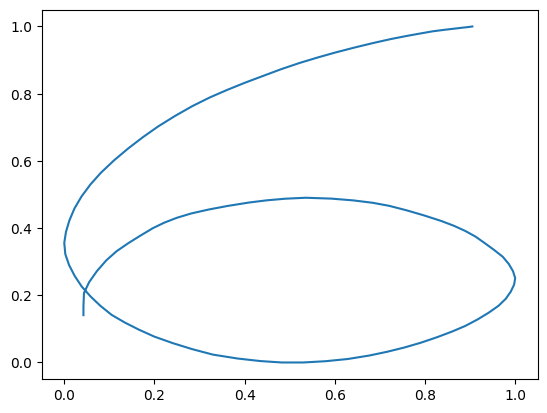

In [29]:
plt.plot(data_0[:, 0], data_0[:, 1])
plt.show()

In [30]:
cs = CanonicalSystem(dt=0.01, ax=1)
dmp1 = SingleDMP(n_bfs=50, cs=cs, device='cpu')
dmp2 = SingleDMP(n_bfs=50, cs=cs, device='cpu')
dmp1.imitate_path(data_0[:, 0])
dmp2.imitate_path(data_0[:, 1])

Show trained weights

weights data type: torch.float32


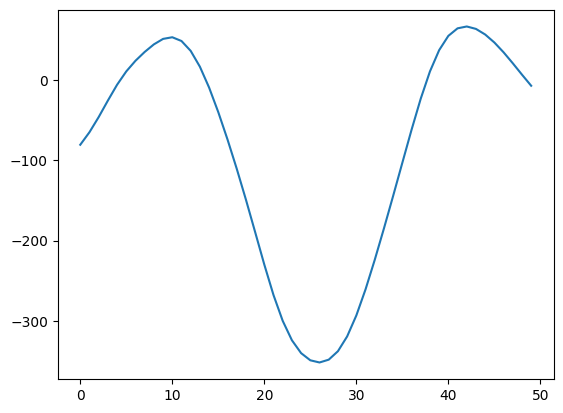

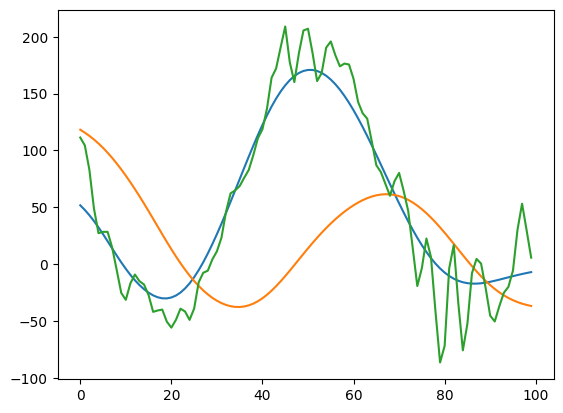

In [31]:
w1 = dmp1.w
print("weights data type:", dmp1.w.dtype)
plt.plot(w1)
plt.show()
force1 = dmp1.gen_force()
force2 = dmp2.gen_force()
target_force = dmp1.gen_target_force(torch.from_numpy(data_0[:, 0]))
plt.plot(force1)
# add legend
plt.plot(force2)
plt.plot(target_force)
plt.show()

Generate new trajectory with noise weights

In [32]:
traj_num = 1000
n_bdf = 50
torque = np.zeros([100, traj_num, 2])
trajectory = np.zeros([100, traj_num, 2])

dmp = SingleDMP(n_bfs=n_bdf, cs=cs, device='cpu')
for j in range(2):
    dmp.imitate_path(data_0[:, j])
    w = dmp.w.detach()
    for i in range(traj_num):
        dmp.w = w + (2*torch.rand(n_bdf) - 1)* 0.3 * w
        trajectory[:, i, j], _, _ = dmp.rollout(y0=data_0[0,j], goal=data_0[-1,j])
        torque[:, i, j] = dmp.gen_force()

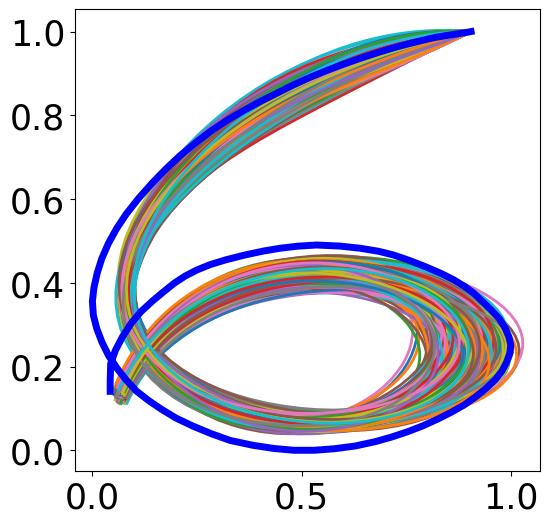

In [33]:
plt.figure(figsize=(6, 6))
plt.plot(trajectory[:, :, 0], trajectory[:, :, 1], linewidth=2)
plt.plot(data_0[:, 0], data_0[:, 1], "b", linewidth=5)
plt.tick_params(labelsize=25)
plt.axis("equal")
plt.savefig("3.png")
plt.show()

Show the generated force

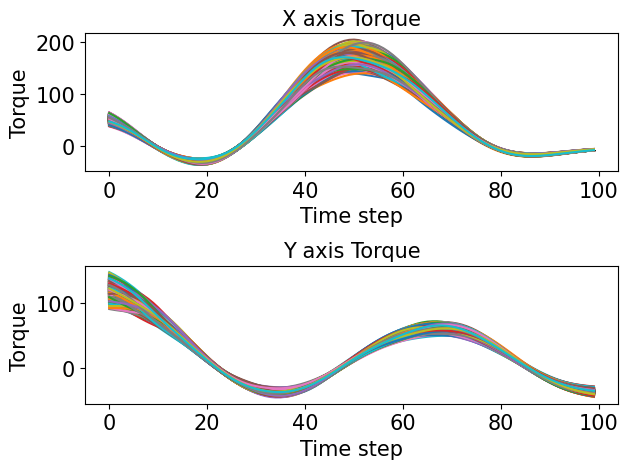

In [34]:
# plot x, y torque
figure, axis = plt.subplots(2, 1)
axis[0].plot(torque[:, :, 0])
axis[1].plot(torque[:, :, 1])
axis[0].tick_params(labelsize=15)
axis[1].tick_params(labelsize=15)

# add legend
axis[0].set_title("X axis Torque", fontsize=15)
axis[1].set_title("Y axis Torque", fontsize=15)
# add label
axis[0].set_ylabel("Torque", fontsize=15)
axis[1].set_ylabel("Torque", fontsize=15)
axis[0].set_xlabel("Time step", fontsize=15)
axis[1].set_xlabel("Time step", fontsize=15)

# set the distance between two subplots
plt.tight_layout()
# save figure
plt.savefig('data_aug_b.png')
plt.show()








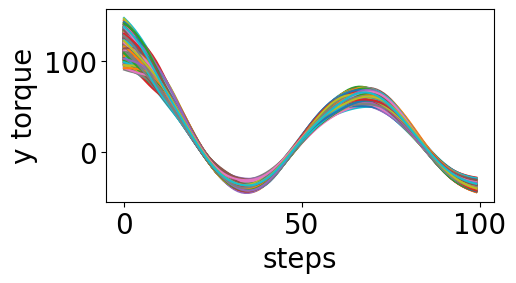

In [35]:
plt.figure(figsize=(5, 2.5))
plt.plot(torque[:, :, 1])
plt.tick_params(labelsize=20)
plt.xlabel("steps", fontsize=20)
plt.ylabel("y torque", fontsize=20)
plt.show()

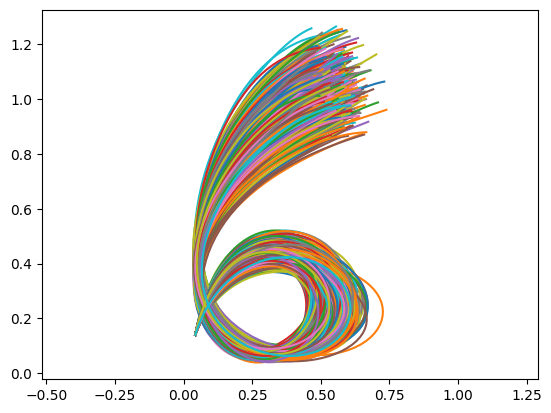

In [37]:
trajectory = (trajectory/trajectory[-1, :, :]) * data_0[-1, :]
plt.plot(trajectory[:, :, 0], trajectory[:, :, 1])
plt.axis("equal")
plt.show()

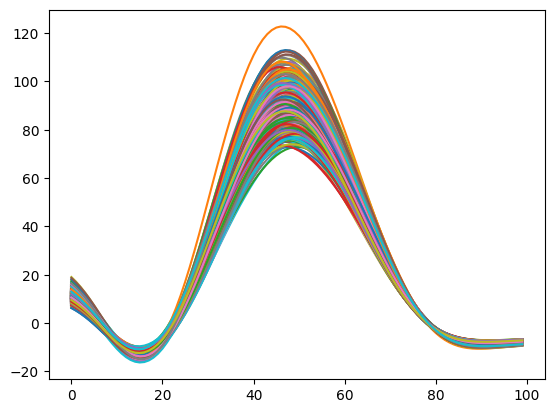

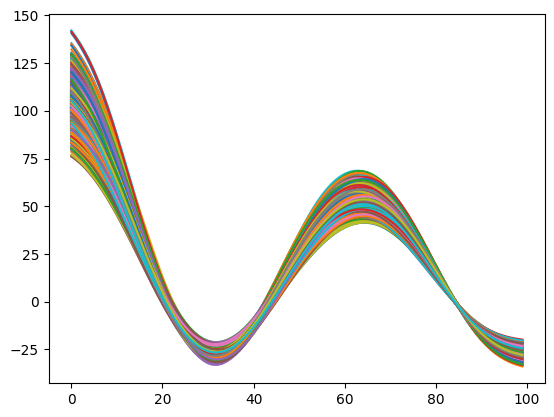

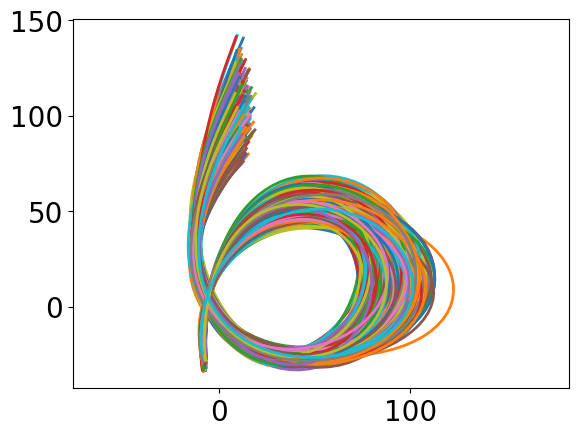

In [38]:
# show the force to learn this trajectory
traj_num = 1000
torque = np.zeros([100, traj_num, 2])

for i in range(traj_num):
    dmp1.imitate_path(trajectory[:, i, 0])
    dmp2.imitate_path(trajectory[:, i, 1])
    torque[:, i, 0] = dmp1.gen_force()
    torque[:, i, 1] = dmp2.gen_force()

plt.plot(torque[:, :, 0])
plt.show()
plt.plot(torque[:, :, 1])
plt.show()
plt.plot(torque[:, :, 0], torque[:, :, 1], linewidth=2)
plt.tick_params(labelsize=20)
# add label for x, y axis
plt.axis("equal")

plt.show()